## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [119]:
import torch
import torch.nn.functional as F

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
from numpy.linalg import norm

import pickle

import os.path

#### Load file

In [120]:
EMBEDDINGS_DIMENSION_SIZE = 50

In [121]:
INPUT_PATH = 'inputs'
INPUT_FILE_NAME = f'glove.6B.{EMBEDDINGS_DIMENSION_SIZE}d.txt'

OUTPUT_PATH = 'outputs'
OUTPUT_FILE_NAME = f'embeddings_dict_{EMBEDDINGS_DIMENSION_SIZE}d.pkl'

In [122]:
def create_emb_dictionary(path):
    """
    Creates a dictionary mapping words to their corresponding embedding vectors 
    from a given file.

    The file should be formatted such that each line contains a word followed 
    by its embedding values, separated by spaces.

    Args:
        path (str): The file path containing the word embeddings.

    Returns:
        dict: A dictionary where keys are words (str) and values are NumPy arrays 
              representing the embedding vectors.

    Example:
        embeddings = create_emb_dictionary("embeddings.txt")
        print(embeddings["hello"])  # Output: array([...], dtype=float32)
    """
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings_dict[word] = vector
    return embeddings_dict

In [123]:
outputFilePath = os.path.join(OUTPUT_PATH, OUTPUT_FILE_NAME)

if os.path.isfile(outputFilePath):
    print("Found embedding dictionary file! Loading data...")
    with open(outputFilePath, 'rb') as f:
        embeddings_dict = pickle.load(f)
else:
    print("No embedding dictionary found, generating embedding cached file...")
    embeddings_dict = create_emb_dictionary(os.path.join(INPUT_PATH, INPUT_FILE_NAME))    

    os.makedirs(OUTPUT_PATH)
    with open(outputFilePath, 'wb') as f:
        pickle.dump(embeddings_dict, f)

No embedding dictionary found, generating embedding cached file...


#### See some embeddings

In [124]:
def show_n_first_words(path, n_words):
    """
    Displays the first `n_words` lines of a word embedding file, showing each word 
    and the length of its corresponding embedding vector.

    Args:
        path (str): The file path containing the word embeddings.
        n_words (int): The number of words to display.

    Example:
        show_n_first_words("embeddings.txt", 5)
        # Output:
        # ['word1', '0.1', '0.2', ...] vector_length
        # ['word2', '0.3', '0.4', ...] vector_length
    """
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            print(line.split(), len(line.split()[1:]))
            if i>=n_words: break

In [125]:
show_n_first_words(os.path.join(INPUT_PATH, INPUT_FILE_NAME), 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [126]:
def plot_embeddings(words2show, embeddings_dict, func=PCA):
    """
    Plots a 3D visualization of word embeddings using dimensionality reduction.

    This function reduces the dimensionality of the given word embeddings using 
    a specified technique (e.g., PCA or t-SNE) and plots the transformed embeddings 
    in a 3D space.

    Args:
        words2show (list of str): A list of words to visualize.
        embeddings_dict (dict): A dictionary mapping words to their embedding vectors.
        func (callable, optional): A dimensionality reduction function (e.g., PCA, TSNE). 
                                   Defaults to PCA.

    Returns:
        None: Displays a 3D scatter plot of the reduced embeddings with annotated words.

    Example:
        plot_embeddings("embeddings.txt", ["king", "queen", "man", "woman"], 300, embeddings_dict, PCA)
    """
    word_vectors = np.array([embeddings_dict[word] for word in words2show if word in embeddings_dict])
    words_filtered = [word for word in words2show if word in embeddings_dict]
    
    if word_vectors.shape[0] == 0:
        print("No words found in the embeddings dictionary.")
        return
    
    reducer = func(n_components=3)
    reduced_embeddings = reducer.fit_transform(word_vectors)
    
    fig = plt.figure(figsize=(12, 14))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], alpha=0.7)
    
    for i, word in enumerate(words_filtered):
        ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], word, fontsize=12)
    
    ax.set_title(f"Word Embeddings Visualization using {func.__name__}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    
    plt.show()


In [127]:
words = ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', 
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']

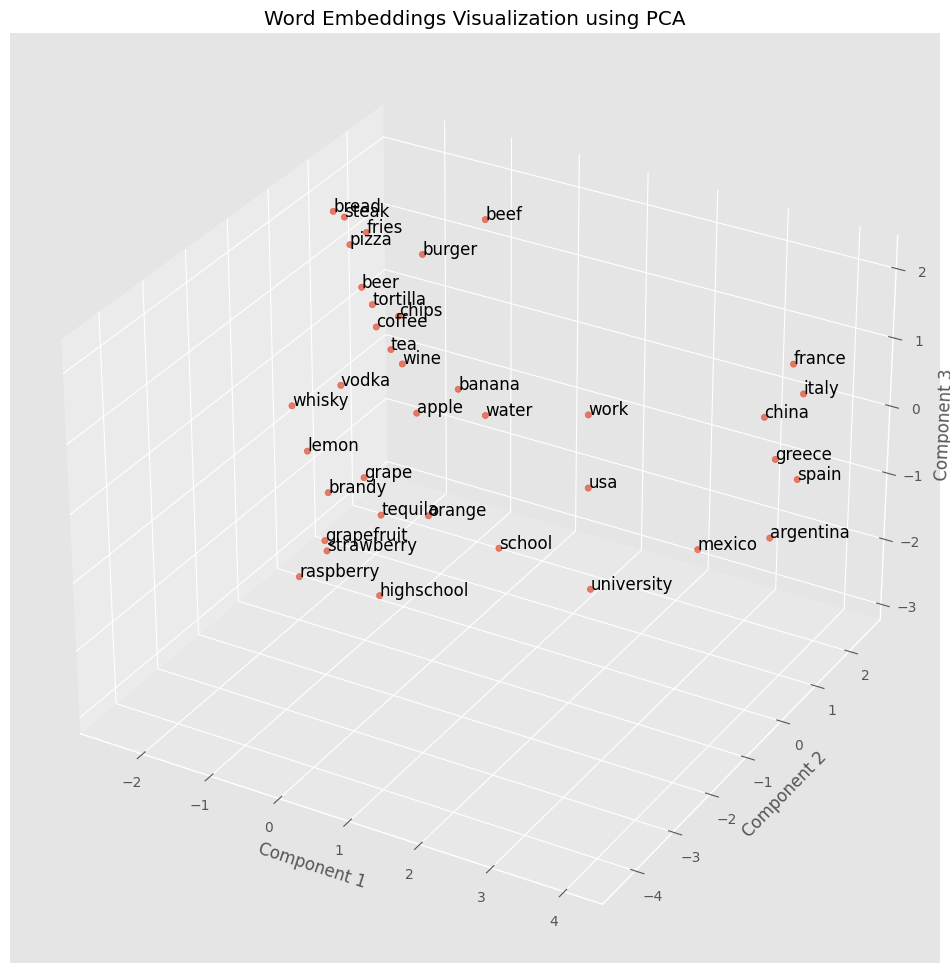

In [128]:
plot_embeddings(words, embeddings_dict, PCA)

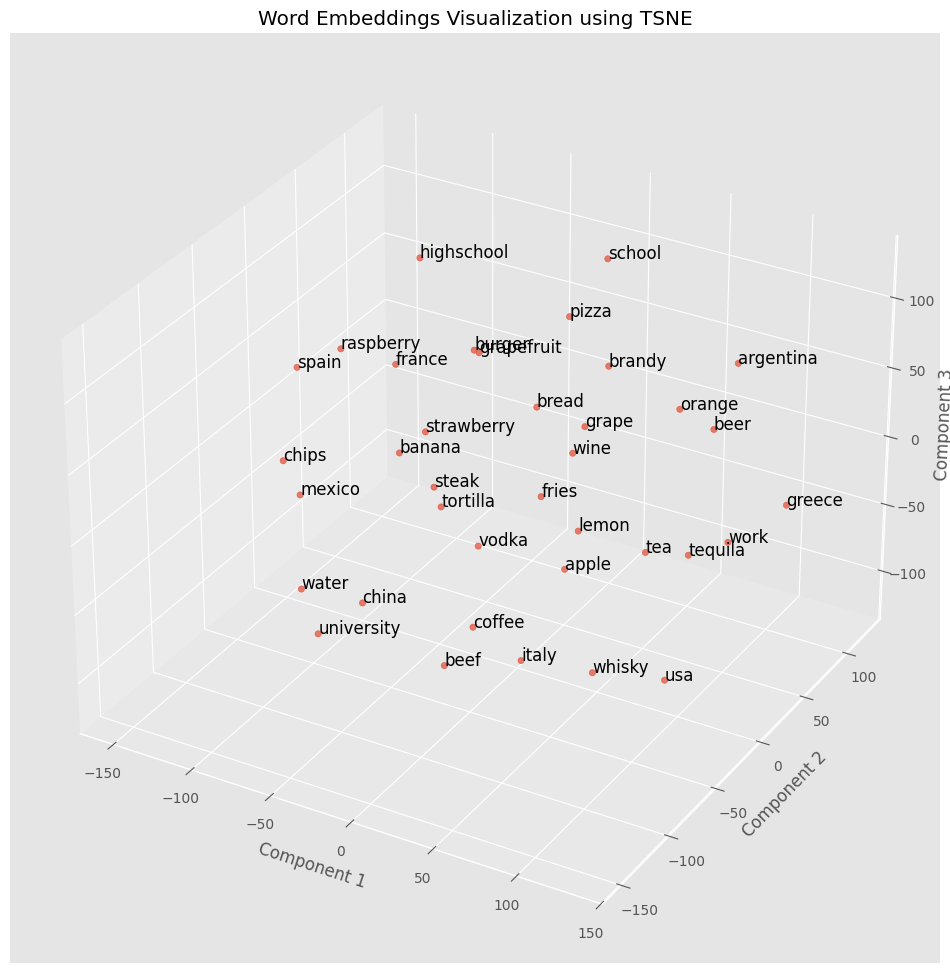

In [129]:
# t-SNE dimensionality reduction for visualization
plot_embeddings(words, embeddings_dict, TSNE)

### Let us compute analogies

We'll use the cosine similarity formula in order to compute the angle between the vectors to get thge similar words.


![img](https://www.researchgate.net/profile/Said-Salloum/publication/345471138/figure/fig2/AS:955431962808321@1604804139868/Cosine-similarity-formula.png)

In [130]:
def find_most_similar_vector(vector, embeddings_dict, top_n=10):
    """
    Finds the most similar word vectors to a given vector based on cosine similarity.

    Args:
        vector (numpy.ndarray): The reference vector to compare against.
        embeddings_dict (dict): A dictionary where keys are words and values are their corresponding embedding vectors.
        top_n (int, optional): The number of most similar words to return. Defaults to 10.

    Returns:
        list of tuples: A sorted list of tuples containing the most similar words and their cosine similarity scores.
                        Format: [(word1, similarity1), (word2, similarity2), ...]

    Example:
        similar_words = find_most_similar_vector(embeddings_dict["king"], embeddings_dict, top_n=5)
        print(similar_words)  
        # Output: [('queen', 0.89), ('prince', 0.85), ('monarch', 0.83), ...]
    """
    similarities = {}
    for other_word, other_vector in embeddings_dict.items():
        similarity = np.dot(vector, other_vector) / (np.linalg.norm(vector) * np.linalg.norm(other_vector))
        similarities[other_word] = similarity

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[1:top_n+1]

One surprising aspect of GloVe vectors is that the directions in the embedding space can be meaningful. The structure of the GloVe vectors certain analogy-like relationship like this tend to hold:
`king − man + woman ≈ queen`

In [131]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    """
    Solves a word analogy of the form: word1 is to word2 as word3 is to X.
    This is done by performing a vector arithmetic operation and finding the most 
    similar word to the resulting vector.

    Args:
        word1 (str): The first word in the analogy.
        word2 (str): The second word in the analogy.
        word3 (str): The third word in the analogy.
        embeddings_dict (dict): A dictionary where keys are words and values are their corresponding embedding vectors.

    Returns:
        list: A list of the most similar words to the resulting analogy vector, based on cosine similarity.

    Example:
        analogy_result = analogy("king", "queen", "man", embeddings_dict)
        print(analogy_result)  
        # Output: [('woman', 0.95), ...]
    """
    if word1 not in embeddings_dict or word2 not in embeddings_dict or word3 not in embeddings_dict:
        return "One or more words not found in the dictionary."
    
    vec1 = embeddings_dict[word1]
    vec2 = embeddings_dict[word2]
    vec3 = embeddings_dict[word3]
    analogy_vector = vec2 - vec1 + vec3
    
    return find_most_similar_vector(analogy_vector, embeddings_dict)

In [132]:
analogy('man', 'king', 'woman', embeddings_dict)

[('queen', np.float32(0.86095804)),
 ('daughter', np.float32(0.7684512)),
 ('prince', np.float32(0.7640699)),
 ('throne', np.float32(0.76349705)),
 ('princess', np.float32(0.7512728)),
 ('elizabeth', np.float32(0.75064886)),
 ('father', np.float32(0.73144966)),
 ('kingdom', np.float32(0.7296158)),
 ('mother', np.float32(0.728001)),
 ('son', np.float32(0.72795373))]

In [133]:
def find_most_similar(word, embeddings_dict, top_n=10):
    """
    Finds the most similar words to a given word based on its embedding vector's 
    cosine similarity with other word vectors in the dictionary.

    Args:
        word (str): The word to find similarities for.
        embeddings_dict (dict): A dictionary where keys are words and values are their corresponding embedding vectors.
        top_n (int, optional): The number of most similar words to return. Defaults to 10.

    Returns:
        list: A list of the most similar words and their cosine similarity scores, 
              sorted in descending order of similarity.
              Format: [(word1, similarity1), (word2, similarity2), ...]

    Example:
        similar_words = find_most_similar("king", embeddings_dict, top_n=5)
        print(similar_words)  
        # Output: [('queen', 0.89), ('prince', 0.85), ('monarch', 0.83), ...]
    """
    if word not in embeddings_dict:
        return "Word not found in dictionary."
    
    word_vector = embeddings_dict[word]
    return find_most_similar_vector(word_vector, embeddings_dict, top_n)

In [134]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [135]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> mexican
2 ---> venezuela
3 ---> colombia
4 ---> peru
5 ---> chile
6 ---> puerto
7 ---> rico
8 ---> cuba
9 ---> guatemala
10 ---> panama
